In [55]:
import random
import torch
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer
from scipy.io import loadmat
import yaml

sys.path.append("../")


from models import  FNN_train, compute_2dFourier_bases, compute_2dpca_bases, count_params
from models.myGkNN6 import myGkNN6

torch.set_printoptions(precision=16)


torch.manual_seed(0)
np.random.seed(0)


###################################
# load configs
###################################
with open('config.yml', 'r', encoding='utf-8') as f:
    config = yaml.full_load(f)

config = config["airfoil_test6"]
config = dict(config)
config_data, config_model, config_train = (
    config["data"],
    config["model"],
    config["train"],
)
downsample_ratio = config_data["downsample_ratio"]
L = config_data["L"]
n_train = config_data["n_train"]
n_test = config_data["n_test"]
device = torch.device(config["train"]["device"])


###################################
# load data
###################################
data_path = "../data/airfoil/"
coordx = np.load(data_path+"NACA_Cylinder_X.npy")
coordy = np.load(data_path+"NACA_Cylinder_Y.npy")
data_in = np.stack((coordx, coordy), axis=3)
data_out = np.load(data_path+"NACA_Cylinder_Q.npy")[:,4,:,:] #density, velocity 2d, pressure, mach number

_, nx, ny, _ = data_in.shape

data_in_ds = data_in[:, 0::downsample_ratio, 0::downsample_ratio, :]
data_out_ds = data_out[:, 0::downsample_ratio, 0::downsample_ratio, np.newaxis]

L=1.0
grid_x, grid_y = np.meshgrid(np.linspace(0, L, nx), np.linspace(0, L, ny))
grid_x, grid_y = grid_x.T, grid_y.T
grid_x_ds = grid_x[0::downsample_ratio, 0::downsample_ratio]
grid_y_ds = grid_y[0::downsample_ratio, 0::downsample_ratio]
# x_train, y_train are [n_data, n_x, n_channel] arrays

print(data_in_ds[0:n_train,:,:,:].shape, np.tile(grid_x_ds, (n_train, 1, 1))[:,:,:, np.newaxis].shape)
# x_train = torch.from_numpy(data_in_ds[0:n_train, :, :, :].astype(np.float32))
x_train = torch.from_numpy(
    np.concatenate(
        (data_in_ds[0:n_train,:,:,:], 
         np.tile(grid_x_ds, (n_train, 1, 1))[:,:,:, np.newaxis],
         np.tile(grid_y_ds, (n_train, 1, 1))[:,:,:, np.newaxis],
        ),
        axis=3,
    ).astype(np.float32)
)

y_train = torch.from_numpy(data_out_ds[0:n_train, :, :, :].astype(np.float32))
# x_test, y_test are [n_data, n_x, n_channel] arrays
# x_test = torch.from_numpy(data_in_ds[-n_test:, :, :, :].astype(np.float32))
x_test = torch.from_numpy(
    np.concatenate(
        (data_in_ds[-n_test:,:,:,:], 
         np.tile(grid_x_ds, (n_test, 1, 1))[:,:,:, np.newaxis],
         np.tile(grid_y_ds, (n_test, 1, 1))[:,:,:, np.newaxis],
        ),
        axis=3,
    ).astype(np.float32)
)

y_test = torch.from_numpy(data_out_ds[-n_test:, :, :, :].astype(np.float32))



x_train = x_train.reshape(x_train.shape[0], -1, x_train.shape[-1])   
x_test = x_test.reshape(x_test.shape[0], -1, x_test.shape[-1])
y_train = y_train.reshape(y_train.shape[0], -1, y_train.shape[-1])   
y_test = y_test.reshape(y_test.shape[0], -1, y_test.shape[-1])
print("x_train.shape: ",x_train.shape)   #torch.Size([1000, 11271, 4])
print("y_train.shape: ",y_train.shape)   #torch.Size([1000, 11271, 1])



###################################
#compute fourier bases
###################################
k_max = max(config_model["GkNN_modes"])
Nx = (nx + downsample_ratio - 1) // downsample_ratio
Ny = (ny + downsample_ratio - 1) // downsample_ratio
gridx, gridy, fbases, weights = compute_2dFourier_bases(Nx, Ny, k_max, L, L)
fbases = fbases.reshape(-1, k_max)
weights = weights.reshape(-1)
wfbases = fbases * np.tile(weights, (k_max, 1)).T
bases_fourier = torch.from_numpy(fbases.astype(np.float32)).to(device)
wbases_fourier = torch.from_numpy(wfbases.astype(np.float32)).to(device)


####################################
#compute pca bases
####################################
k_max = 1024
Nx = (nx + downsample_ratio - 1) // downsample_ratio
Ny = (ny + downsample_ratio - 1) // downsample_ratio
pca_data_in_1 = data_in_ds[:,:,:,0].reshape((data_in_ds.shape[0], -1 ))

pca_data_in_2 = data_in_ds[:,:,:,1].reshape((data_in_ds.shape[0], -1 ))
# pca_data_in = data_in_ds[0:n_train, :, :, :].reshape((n_train*data_in_ds.shape[-1], -1 ))

pca_data_out = data_out_ds[0:n_train, :, :, :].reshape((n_train, -1))

print("Start SVD with data shape: ", pca_data_out.shape)
U, S, VT = np.linalg.svd(pca_data_in_1.T, full_matrices=False)
fbases = U[:, 0:k_max//2] / np.sqrt(L * L / (Nx*Ny))
wfbases = L * L / (Nx*Ny) * fbases
bases_pca_1 = torch.from_numpy(fbases.astype(np.float32))
wbases_pca_1 = torch.from_numpy(wfbases.astype(np.float32))

U, S, VT = np.linalg.svd(pca_data_in_2.T, full_matrices=False)
fbases = U[:, 0:k_max//2] / np.sqrt(L * L / (Nx*Ny))
wfbases = L * L / (Nx*Ny) * fbases
bases_pca_2 = torch.from_numpy(fbases.astype(np.float32))
wbases_pca_2 = torch.from_numpy(wfbases.astype(np.float32))

bases_pca_in = torch.cat((bases_pca_1,bases_pca_2),dim=-1)
wbases_pca_in = torch.cat((wbases_pca_1,wbases_pca_2),dim=-1)
bases_pca_in, wbases_pca_in = bases_pca_in.to(device), wbases_pca_in.to(device)
# U, S, VT = np.linalg.svd(pca_data_in.T, full_matrices=False)
# fbases = U[:, 0:k_max] / np.sqrt(L * L / (Nx*Ny))
# wfbases = L * L / (Nx*Ny) * fbases
# bases_pca = torch.from_numpy(fbases.astype(np.float32))
# wbases_pca = torch.from_numpy(wfbases.astype(np.float32))
# bases_pca_in, wbases_pca_in = bases_pca.to(device), wbases_pca.to(device)


U, S, VT = np.linalg.svd(pca_data_out.T, full_matrices=False)
fbases = U[:, 0:k_max] / np.sqrt(L * L / (Nx*Ny))
wfbases = L * L / (Nx*Ny) * fbases
bases_pca = torch.from_numpy(fbases.astype(np.float32))
wbases_pca = torch.from_numpy(wfbases.astype(np.float32))
bases_pca_out, wbases_pca_out = bases_pca.to(device), wbases_pca.to(device)



###################################
#compute kernel bases
###################################

H_in = 0
H_out = 0


bases_list = [bases_fourier, wbases_fourier, bases_pca_in, wbases_pca_in, bases_pca_out, wbases_pca_out]
from models import UnitGaussianNormalizer
x_normalizer = UnitGaussianNormalizer(x_train, dim=[])
y_normalizer = UnitGaussianNormalizer(y_train, dim=[])


(1000, 221, 51, 2) (1000, 221, 51, 1)
x_train.shape:  torch.Size([1000, 11271, 4])
y_train.shape:  torch.Size([1000, 11271, 1])
Start SVD with data shape:  (2000, 11271)


torch.Size([11271, 96])


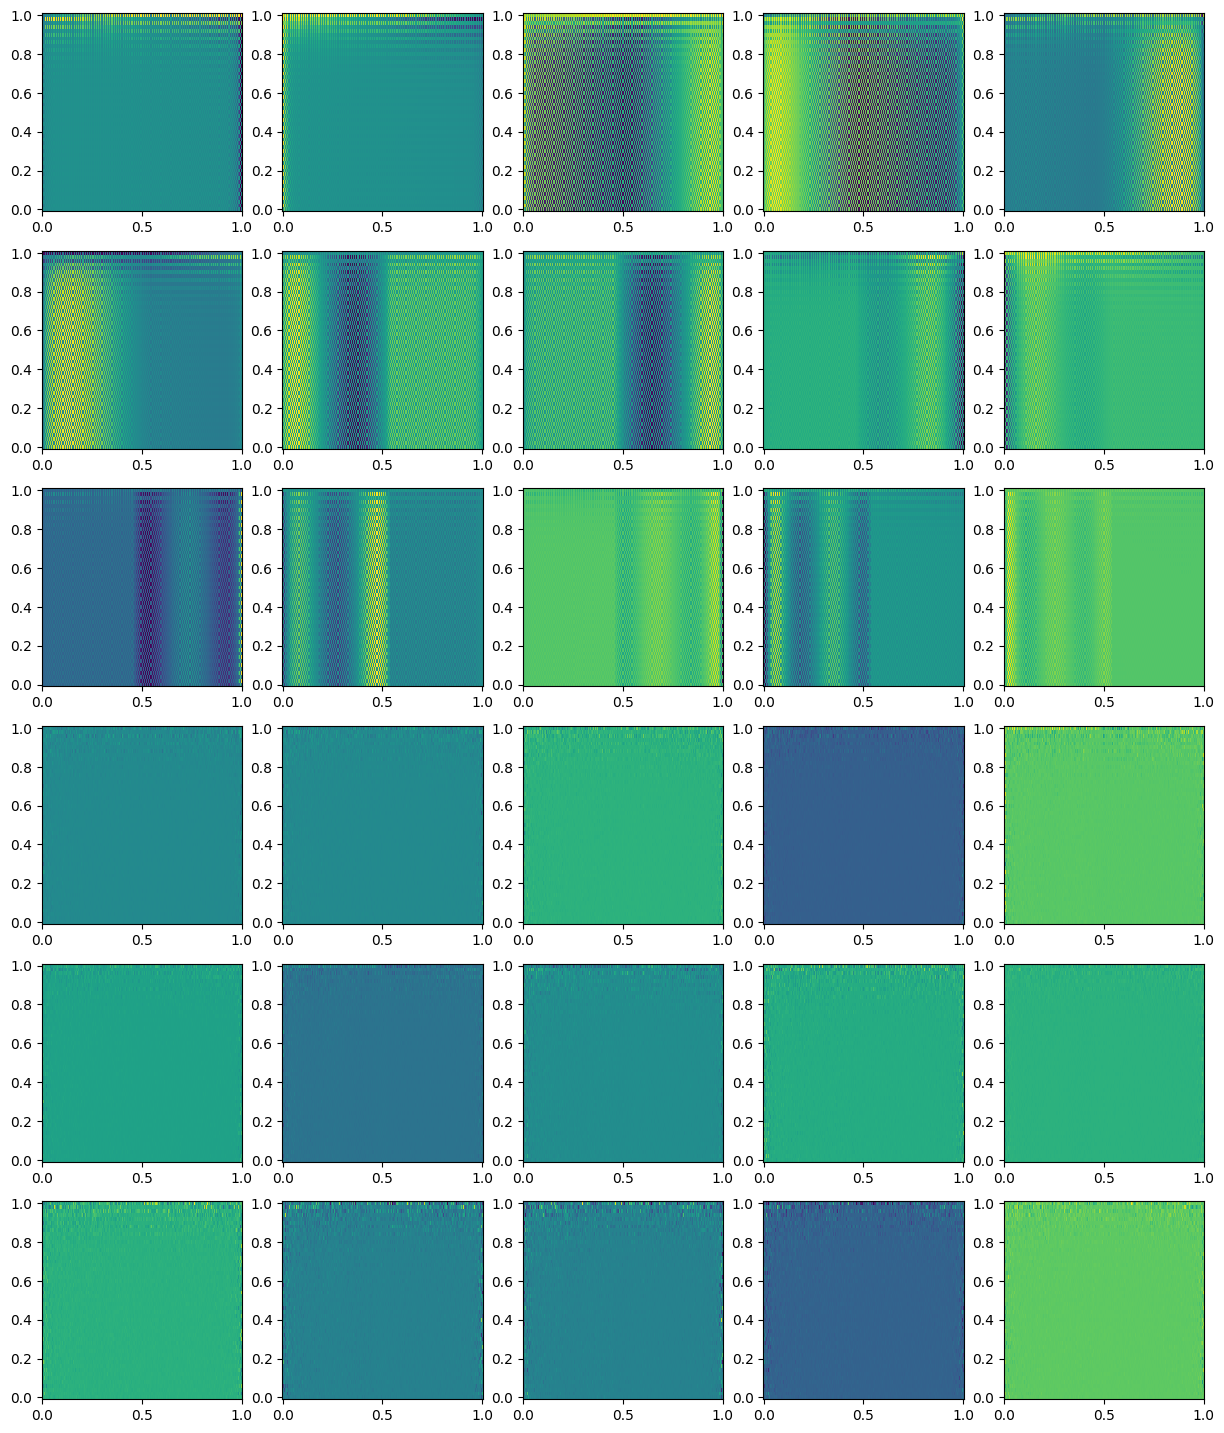

In [48]:
from models import UnitGaussianNormalizer
x_normalizer = UnitGaussianNormalizer(x_train, dim=[])
y_normalizer = UnitGaussianNormalizer(y_train, dim=[])
print(bases_pca.shape)
bases_pca = bases_pca_in
wbases_pca = wbases_pca_in
bases_pca_2d = bases_pca.reshape(Nx,Ny,k_max).to('cpu')
wbases_pca_2d = wbases_pca.reshape(Nx,Ny,k_max).to('cpu')

mygridx = np.linspace(0, L, Nx)
mygridy = np.linspace(0, L, Ny)
grid_x, grid_y = np.meshgrid(mygridx, mygridy)
m=6
n=5
fig, axs = plt.subplots(m, n, figsize=(3*n,3*m))
for i in range(5):
    axs[0,i].pcolormesh(grid_x.T, grid_y.T, bases_pca_2d[:,:,i])
    axs[1,i].pcolormesh(grid_x.T, grid_y.T, bases_pca_2d[:,:,i+5])
    axs[2,i].pcolormesh(grid_x.T, grid_y.T, bases_pca_2d[:,:,i+10])
    axs[3,i].pcolormesh(grid_x.T, grid_y.T, bases_pca_2d[:,:,i+k_max//2])
    axs[4,i].pcolormesh(grid_x.T, grid_y.T, bases_pca_2d[:,:,i+5+k_max//2])
    axs[5,i].pcolormesh(grid_x.T, grid_y.T, bases_pca_2d[:,:,i+10+k_max//2])

torch.Size([1, 11271])
torch.Size([1, 11271])
tensor([[40., 40., 40.,  ..., 40., 40., 40.]]) tensor([[42.8122863769531250, 40.2846717834472656, 52.3242874145507812,
          ..., 23.7404479980468750, 39.8217697143554688,
         39.7356338500976562]])
0.7264300584793091
torch.Size([1, 11271])
torch.Size([1, 11271])
tensor([[40., 40., 40.,  ..., 40., 40., 40.]]) tensor([[42.8122863769531250, 40.2846717834472656, 52.3242874145507812,
          ..., 23.7404479980468750, 39.8217697143554688,
         39.7356338500976562]])
0.7264300584793091
torch.Size([1, 11271])
torch.Size([1, 11271])
tensor([[40., 40., 40.,  ..., 40., 40., 40.]]) tensor([[42.8122863769531250, 40.2846717834472656, 52.3242874145507812,
          ..., 23.7404479980468750, 39.8217697143554688,
         39.7356338500976562]])
0.7264300584793091
torch.Size([1, 11271])
torch.Size([1, 11271])
tensor([[40., 40., 40.,  ..., 40., 40., 40.]]) tensor([[42.8122863769531250, 40.2846717834472656, 52.3242874145507812,
          ..., 2

C:\Users\15461\AppData\Local\Temp\ipykernel_28520\542553401.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


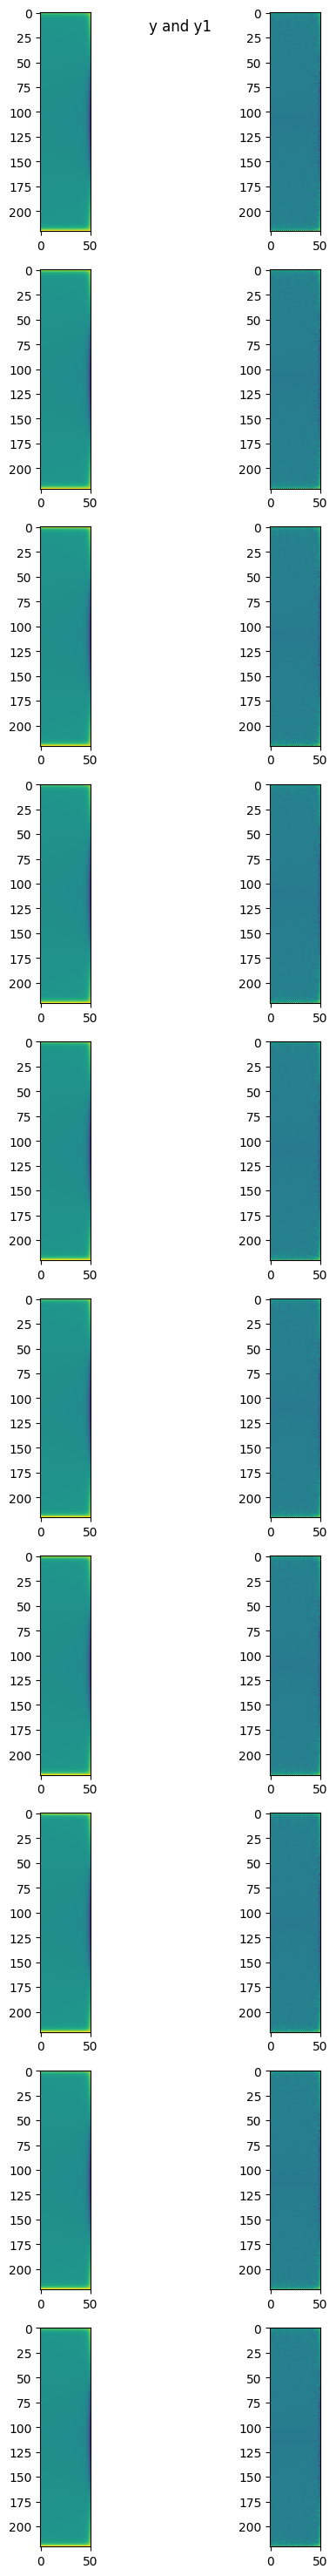

In [56]:
n = 10
bases0 = bases_pca_in
wbases0 = wbases_pca_in
bases = bases0[:,:1024]
wbases = wbases0[:,:1024]

from models.losses import LpLoss
myloss = LpLoss(d=1, p=2, size_average=False)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,3*n))
plot = 'x'
for i in range(n):
    if plot == 'x':
        x = x_test[i].permute(1,0).to('cuda')[:1,:]
        # x = x_normalizer.encode(x)

        print(x.shape)  #torch.Size([4, 11271])
        x_hat = torch.einsum("cx,xk->ck", x, wbases)
        # print(x_hat.shape,bases.shape)

        x1 = torch.real(torch.einsum("ck,xk->cx", x_hat, bases)).to('cpu')
        print(x1.shape)
        x = x.to('cpu')
        # x = x_normalizer.decode(x).to('cpu')
        # x1 = x_normalizer.decode(x1).to('cpu')
        loss1 = myloss(x, x1)
        ax = fig.add_subplot(n, 2, i*2 + 1)
        ax.imshow(x[0,:].reshape(Nx,Ny).squeeze())
        ax = fig.add_subplot(n, 2, i*2 + 2)
        ax.imshow(x1[0,:].reshape(Nx,Ny).squeeze())
        print(x,x1)
        print(loss1.item())
    elif plot =='y':
        y = y_test[i].permute(1,0).to('cuda')

        # print(y.shape)
        y_hat = torch.einsum("cx,xk->ck", y, wbases)
        # print(y_hat.shape,bases.shape)

        y1 = torch.real(torch.einsum("ck,xk->cx", y_hat, bases))
        # print(y1.shape)
        y = y_normalizer.decode(y).to('cpu')
        y1 = y_normalizer.decode(y1).to('cpu')
        loss1 = myloss(y, y1)
        ax = fig.add_subplot(n, 2, i*2 + 1)
        ax.imshow(y.reshape(Nx,Ny).squeeze())
        ax = fig.add_subplot(n, 2, i*2 + 2)
        ax.imshow(y1.reshape(Nx,Ny).squeeze())
        print(loss1.item())

    




fig.suptitle('y and y1', y=0.98)
plt.tight_layout()
fig.show()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
print(torch.ones(3).shape)
tensor  = torch.randn(1000, dtype=float)
print(F.softmax(tensor, dim=0))

torch.Size([3])
tensor([2.4365e-04, 1.2780e-02, 2.3656e-03, 3.5683e-04, 7.4206e-04, 8.9275e-04,
        5.1174e-04, 4.1806e-04, 8.9894e-04, 1.0787e-03, 1.4490e-03, 2.7462e-04,
        1.1459e-02, 1.4103e-03, 1.6771e-04, 2.8959e-03, 1.5293e-03, 1.0350e-04,
        2.0327e-04, 3.7008e-04, 2.1918e-04, 3.9295e-04, 1.1891e-03, 7.2790e-04,
        2.0732e-04, 3.4723e-04, 2.7747e-04, 2.6271e-04, 5.2693e-04, 6.3396e-05,
        4.5773e-04, 3.9858e-04, 7.8613e-04, 4.7923e-04, 3.8058e-04, 6.3822e-04,
        1.0297e-03, 5.2516e-04, 3.4578e-04, 1.1691e-04, 1.4065e-03, 2.4506e-04,
        1.9534e-04, 1.9733e-03, 1.8263e-04, 1.2931e-04, 7.5576e-04, 2.1633e-03,
        1.0771e-03, 2.7526e-03, 1.6801e-04, 1.8406e-03, 1.9123e-03, 6.8286e-04,
        4.4568e-04, 9.9057e-04, 5.1691e-04, 1.7838e-03, 1.4654e-03, 9.6906e-04,
        2.2698e-03, 5.7470e-04, 6.1759e-04, 7.6056e-04, 9.4086e-05, 2.2650e-04,
        6.0647e-04, 1.5839e-03, 3.0977e-04, 7.1704e-04, 2.2656e-03, 1.0126e-03,
        3.5933e-04, 1.56